### ensemble(앙상블)
- 모델이 여러개
- 각각의 모델을 학습시킴
- 각 모델에 입력 parameter(이미지 픽셀)을 넣어서 예측값을 알아냄

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./data/mnist/train.csv")
n = int(train_csv.shape[0] * 0.8)
test_csv = train_csv.loc[n:, :]
train_csv = train_csv.loc[:n-1, :]
real_test_csv = pd.read_csv("./data/mnist/test.csv")



### 0. 전처리
- 데이터를 test/train으로 나눠준다

### 1. NN학습
- CNN으로 학습
- xaviers init
- dropout
- adam optimzer

### 2. batch / epoch 나눠서 학습


In [2]:
# real data
x_real_test_data = real_test_csv

x_train_data.shape : (33600, 784), y_train_data.shape : (33600, 10)
x_test_data.shape : (8400, 784), y_test_data.shape : (8400, 10)


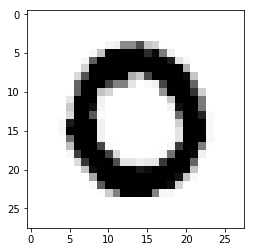

In [3]:
x_train_data = train_csv.drop("label", axis = 1)
y_train_data = pd.get_dummies(train_csv["label"])

x_test_data = test_csv.drop("label", axis = 1)
y_test_data = pd.get_dummies(test_csv["label"])

print("x_train_data.shape : {}, y_train_data.shape : {}".format(x_train_data.shape,y_train_data.shape))
print("x_test_data.shape : {}, y_test_data.shape : {}".format(x_test_data.shape,y_test_data.shape))

img = (x_train_data.loc[1,:].values).reshape(28,28)
# 0번째 행의 숫자 그려보기 
plt.imshow(img, cmap="Greys")
plt.show()

In [4]:
x_test_data = pd.DataFrame(x_test_data.values, columns=x_test_data.columns)
y_test_data = pd.DataFrame(y_test_data.values, columns=y_test_data.columns)

In [5]:
def set_weight(w_name, w_shape):
    return tf.get_variable(name =w_name, shape = w_shape,initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)

def set_bias(b_name, b_shape):
    return tf.Variable(tf.random_normal(b_shape), name = b_name, dtype =tf.float32)

def get_total_n(data, batch_size):
    return int(data.shape[0] / batch_size)


### LeNet (28x28 mnist)
- layer1
    - 1차원의 input 28x28
    - 3x3(1차원)필터 32개로 conv, padding = SAME
    - relu 후 pooling(2x2, strides = 2)
    - 12x12(1차원) 32개가 나옴
- layer2
    - 12x12(1차원) 32개를 input
    - 3x3(32차원)필터 64개로 conv, padding = SAME
    - relu 후 pooling(2x2, strides = 2)
    - 7x7(1차원)64개가 나옴
- fully connected
    - 7x7x16 (input)
    - 256 (hidden1)
    - 256 (hidden2)
    - 10 (output)


### class화

In [125]:
import math 

class CNNModel:
    def __init__(self,sess, name):
        self.name = name 
        self.sess = sess
        
    # tensorflow graph 구현부분
    def create_network(self,input_x,input_y):
        with tf.variable_scope(self.name):
            self.X = tf.placeholder(shape = [None, input_x], dtype = tf.float32)
            self.Y = tf.placeholder(shape = [None, input_y], dtype = tf.float32)
            self.keep_rate = tf.placeholder(dtype= tf.float32)
            
            X_img = tf.reshape(self.X, shape = [-1, int(math.sqrt(input_x)), int(math.sqrt(input_x)), 1])
            
            W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
            L1 = tf.nn.conv2d(X_img, W1, strides = [1,1,1,1], padding = "SAME")
            
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

            W2 = set_weight("weight2", [3,3,32,64])
            L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
            
            FC = tf.reshape(L2, shape=[-1, 7*7*64])

            FC_W1 = set_weight("fc_weight1", [7*7*64, 256])
            FC_b1 = set_bias( "fc_bias1", [256])
            _FC_L1 = tf.nn.relu(tf.matmul(FC,FC_W1) + FC_b1)
            FC_L1 = tf.nn.dropout(_FC_L1, keep_prob = self.keep_rate) 

            FC_W2 = set_weight("fc_weight2", [256, 256])
            FC_b2 = set_bias( "fc_bias2", [256])
            _FC_L2 = tf.nn.relu(tf.matmul(FC_L1,FC_W2) + FC_b2)
            FC_L2 = tf.nn.dropout(_FC_L2, keep_prob = self.keep_rate) 


            FC_W3 = set_weight("fc_weight3", [256, 10])
            FC_b3 = set_bias( "fc_bias3", [10])

            self.logit = tf.matmul(FC_L2, FC_W3) + FC_b3
            self.H = tf.nn.softmax(self.logit)

            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logit, labels = self.Y))
            optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.train = optimizer.minimize(self.cost)
            
            self.sess.run(tf.global_variables_initializer())
    # batch size로 트레이닝
    def batch_train(self,epoch_size, batch_size, features, label):
        iter_of_num = int(features.shape[0] / batch_size)
        for ep in range(epoch_size):
            batch_start = 0
            for i in range(iter_of_num):
                batch_end = batch_start + batch_size
                # 마지막 iteration에서는 100개가 딱 안맞을수도 있음
                if i == iter_of_num-1:
                    x_batch = features.loc[batch_start:, :]
                    y_batch = label.loc[batch_start:, :]
                    _, self.cost_val = self.sess.run([self.train, self.cost], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.7})
                else:
                    x_batch = features.loc[batch_start:batch_end-1, :]
                    y_batch = label.loc[batch_start:batch_end-1, :]
                    _, self.cost_val = self.sess.run([self.train, self.cost], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.7})
                    batch_start = batch_end
            print("cost_val : {}".format(self.cost_val))
    # batch size로 accuracy 측정
    def batch_accuracy(self, batch_size, features, label):
        predict = tf.argmax(self.H, axis = 1)
        correct = tf.equal(predict, tf.argmax(self.Y, axis = 1))
        accuracy = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))
        
        iter_of_num = int(features.shape[0] / batch_size)
        
        result = 0
        batch_start = 0
        for i in range(iter_of_num):
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                x_batch = features.loc[batch_start:,:]
                y_batch = label.loc[batch_start:,:]
                accuracy_batch = self.sess.run(accuracy, feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:1.0})
                
            else:
                x_batch = features.loc[batch_start:batch_end-1,:]
                y_batch = label.loc[batch_start:batch_end-1,:]
                batch_start = batch_end
                accuracy_batch = self.sess.run(accuracy, feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:1.0})
                
            result += accuracy_batch
        return (result/features.shape[0])

    #batch size로 예측
    def batch_predict(self, batch_size, features):
        predict = tf.argmax(self.H, axis = 1)
        
        iter_of_num = int(features.shape[0] / batch_size)
        
        predict_list = []
        result = []
        batch_start = 0
        for i in range(iter_of_num):
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                x_batch = features.loc[batch_start:, :]
                predict_list = self.sess.run(predict, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            else:
                x_batch = features.loc[batch_start:batch_end-1, :]
                batch_start = batch_end
                predict_list = self.sess.run(predict, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            for i in predict_list:
                result.append(i)
        return result
        
    def get_hypothesis(self, batch_size, features):
        iter_of_num = int(features.shape[0] / batch_size)
        hypo_np = np.zeros([1,10])
        batch_start = 0
        for i in range(iter_of_num):
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                x_batch = features.loc[batch_start:, :]
                hypo = self.sess.run(self.logit, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            else:
                x_batch = features.loc[batch_start:batch_end-1, :]
                batch_start = batch_end
                hypo = self.sess.run(self.logit, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            hypo_np = np.append(hypo_np, hypo,axis=0)
        return hypo_np

In [126]:
tf.reset_default_graph()

In [127]:
cnn_list = []
sess= tf.Session()

for i in range(10):
    cnnmodel = CNNModel(sess, "cnn_"+str(i))
    cnnmodel.create_network(784,10)
    cnn_list.append(cnnmodel)


In [ ]:
for d,cnn in enumerate(cnn_list):
    print("cnn_{} training".format(d))
    cnn.batch_train(15, 100, x_train_data, y_train_data)

cnn_0 training
cost_val : 0.4311543405056
cost_val : 0.1892050951719284
cost_val : 0.0848303958773613
cost_val : 0.15409253537654877
cost_val : 0.04941967502236366
cost_val : 0.0320371575653553
cost_val : 0.05674714967608452
cost_val : 0.06724810600280762
cost_val : 0.0452830046415329
cost_val : 0.024843337014317513
cost_val : 0.011378995142877102
cost_val : 0.00932261161506176
cost_val : 0.019301051273941994
cost_val : 0.006928265560418367
cost_val : 0.022181648761034012
cnn_1 training
cost_val : 0.3308035731315613
cost_val : 0.21823877096176147
cost_val : 0.10943160951137543
cost_val : 0.045206233859062195
cost_val : 0.052007995545864105
cost_val : 0.0617498978972435
cost_val : 0.08480658382177353
cost_val : 0.0466470904648304
cost_val : 0.03433933109045029
cost_val : 0.019519172608852386
cost_val : 0.05066152662038803
cost_val : 0.00460270419716835
cost_val : 0.016279008239507675
cost_val : 0.02656804397702217
cost_val : 0.03386986255645752
cnn_2 training
cost_val : 0.27158811688423

In [ ]:
for d,cnn in enumerate(cnn_list):
    print("cnn_{} accuracy : {}".format(d, cnn.batch_accuracy(100, x_test_data, y_test_data)))

In [ ]:
sum_hypo = 0
for cnn in cnn_list:
    # hypothesis를 더할떄 np.zero(10)에 append해줬기때문에 첫행 빼고 더해준다
    cnn_hypo = cnn.get_hypothesis(100, x_test_data)[1:]
    sum_hypo += cnn_hypo
print("sum_hypo.shape : {}".format(sum_hypo.shape))

In [ ]:
ensemble_predict = sess.run(tf.argmax(sum_hypo, axis = 1))
print("ensemble_predict : {}".format(ensemble_predict.shape))

### ensemble accuracy

In [ ]:
correct = tf.equal(ensemble_predict, tf.argmax(y_test_data, axis = 1))
predict = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))
accuracy = (sess.run(predict)/y_test_data.shape[0])
print(accuracy)

# 앙상블 전 99%

In [595]:
# tensorflow 초기화
tf.reset_default_graph()


# placeholder 
X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
keep_rate = tf.placeholder(dtype= tf.float32)

# input conv img
X_img = tf.reshape(X, shape = [-1, 28,28,1])

W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides = [1,1,1,1], padding="SAME")
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

W2 = set_weight("weight2", [3,3,32,64])
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print(L2)
FC = tf.reshape(L2, shape=[-1, 7*7*64])

FC_W1 = set_weight("fc_weight1", [7*7*64, 256])
FC_b1 = set_bias( "fc_bias1", [256])
_FC_L1 = tf.nn.relu(tf.matmul(FC,FC_W1) + FC_b1)
FC_L1 = tf.nn.dropout(_FC_L1, keep_prob = keep_rate) 

FC_W2 = set_weight("fc_weight2", [256, 256])
FC_b2 = set_bias( "fc_bias2", [256])
_FC_L2 = tf.nn.relu(tf.matmul(FC_L1,FC_W2) + FC_b2)
FC_L2 = tf.nn.dropout(_FC_L2, keep_prob = keep_rate) 


FC_W3 = set_weight("fc_weight3", [256, 10])
FC_b3 = set_bias( "fc_bias3", [10])

logit = tf.matmul(FC_L2, FC_W3) + FC_b3
H = tf.nn.softmax(logit)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 1
batch_size = 100

# loc는 이상,이하로 범위 슬라이싱 
for step in range(train_epoch):
    num_of_iter = get_total_n(x_train_data, batch_size)
    batch_start = 0
    for i in range(num_of_iter):
        batch_next = batch_start + batch_size
        if i ==  num_of_iter-1:
            xtd = x_train_data.loc[batch_start:,:]
            ytd = y_train_data.loc[batch_start:,:]
            _, cost_val = sess.run([train,cost], feed_dict={X: xtd, Y: ytd, keep_rate: 0.7})
        else:
            xtd = x_train_data.loc[batch_start:batch_next-1,:]
            ytd = y_train_data.loc[batch_start:batch_next-1,:]
            _, cost_val = sess.run([train,cost], feed_dict={X: xtd, Y: ytd, keep_rate: 0.7})
            batch_start = batch_next
    if step % 5 == 0:
        print("cost_val : {}".format(cost_val))
           


Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
cost_val : 0.4273631274700165


In [596]:
x_test_data = pd.DataFrame(x_test_data.values, columns=x_test_data.columns)
y_test_data = pd.DataFrame(y_test_data.values, columns=y_test_data.columns)

In [598]:
predict = tf.argmax(H, axis = 1)

correct = tf.equal(predict, tf.argmax(Y, axis = 1))
accuracy = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))

num_iter = get_total_n(x_test_data, batch_size)
batch_start = 0
accuracy_sum = 0

for i in range(num_iter):
    batch_next = batch_start + batch_size
    if i ==  num_of_iter-1:
        xtd = x_test_data.loc[batch_start:,:]
        ytd = y_test_data.loc[batch_start:,:]
        batch_sum = sess.run(accuracy, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
    else:
        xtd = x_test_data.loc[batch_start:batch_next-1,:]
        ytd = y_test_data.loc[batch_start:batch_next-1,:]
        #print("xtd.shape : {}, ytd.shape : {}".format(xtd.shape, ytd.shape))
        batch_sum = sess.run(accuracy, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
        a = sess.run(predict, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
        #print("batch_sum : {}, start : {}, end : {}".format(batch_sum,batch_start, batch_next))
        batch_start = batch_next
        
    accuracy_sum += batch_sum
print("accuracy : {}".format((accuracy_sum/x_test_data.shape[0])))
print(a.shape)

<class 'tensorflow.python.framework.ops.Tensor'>
accuracy : 0.9557142857142857
(100,)


### test data 예측

In [39]:
accuracy_list = []
result = []
num_iter = x_real_test_data.shape[0]
batch_size = 100
batch_start = 0
for i in range(num_iter):
    batch_next = batch_start + batch_size
    if i ==  num_of_iter-1:
        xtd = x_real_test_data.loc[batch_start:,:]
        ytd = x_real_test_data.loc[batch_start:,:]
        accuracy_list = sess.run(predict, feed_dict={X: xtd, keep_rate: 1.0})
    else:
        xtd = x_real_test_data.loc[batch_start:batch_next-1,:]
        ytd = x_real_test_data.loc[batch_start:batch_next-1,:]
        #print("xtd.shape : {}, ytd.shape : {}".format(xtd.shape, ytd.shape))
        accuracy_list = sess.run(predict, feed_dict={X: xtd, keep_rate: 1.0})
        #print("batch_sum : {}, start : {}, end : {}".format(batch_sum,batch_start, batch_next))
        batch_start = batch_next
    for r in accuracy_list:
        result.append(r)

In [40]:
df_predict = pd.DataFrame(result, columns = ["label"])
digit_predict = pd.concat([df_predict, x_real_test_data], axis = 1)
print(digit_predict.shape)
digit_predict.to_csv("digit_predict.csv", sep = ',',index=False)


(28000, 785)


In [41]:
data = pd.read_csv("./digit_predict.csv",sep=",")
label_ = data["label"]
ImageId_ = np.arange(1,28001)

In [42]:
digit_pd = pd.DataFrame(ImageId_,columns=["ImageId"])
digit_pd["Label"] = label_

In [43]:
digit_pd.to_csv("digit_pd.csv", sep = ',',index=False)